In [1]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml
import numpy as np

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [3]:
%load_ext autoreload
%autoreload 2

# Load dataset

### Wu 2020 3k (toy dataset from Scirpy)

In [4]:
wu2020 = sc.read_h5ad('../data/Wu_2020/wu2020_3k.h5ad')
wu2020

AnnData object with n_obs × n_vars = 3000 × 30727
    obs: 'cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'has_ir', 'batch'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap_orig'

In [5]:
pd.set_option('display.max_columns', None)
wu2020.obs

,cluster_orig,patient,sample,source,clonotype_orig,multi_chain,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,IR_VJ_1_junction_ins,IR_VJ_2_junction_ins,IR_VDJ_1_junction_ins,IR_VDJ_2_junction_ins,IR_VJ_1_expr,IR_VJ_2_expr,IR_VDJ_1_expr,IR_VDJ_2_expr,IR_VJ_1_v_gene,IR_VJ_2_v_gene,IR_VDJ_1_v_gene,IR_VDJ_2_v_gene,IR_VJ_1_d_gene,IR_VJ_2_d_gene,IR_VDJ_1_d_gene,IR_VDJ_2_d_gene,IR_VJ_1_j_gene,IR_VJ_2_j_gene,IR_VDJ_1_j_gene,IR_VDJ_2_j_gene,IR_VJ_1_c_gene,IR_VJ_2_c_gene,IR_VDJ_1_c_gene,IR_VDJ_2_c_gene,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,IR_VDJ_1_cdr3_nt,IR_VDJ_2_cdr3_nt,has_ir,batch
LN1_GTAGGCCAGCGTAGTG-1-19,4.4-FOS,Lung1,LN1,NAT,lung1.tn.C223,False,nan,nan,TRB,TRB,None,None,CASSLMRLAGDTQYF,CASRLAVLSTSGSVGETQYF,None,None,None,None,NaN,nan,3.0,2.0,nan,nan,TRBV7-2,TRBV12-3,NaN,nan,TRBD2,TRBD2,nan,nan,TRBJ2-3,TRBJ2-5,nan,nan,TRBC2,TRBC2,None,None,TGTGCCAGCAGCTTAATGCGGCTAGCGGGAGATACGCAGTATTTT,TGTGCAAGTCGCTTAGCGGTTTTATCGACTAGCGGGAGTGTCGGAG...,True,19
RN2_AGAGCGACAGATTGCT-1-27,4.4-FOS,Renal2,RN2,NAT,renal2.tnb.C1362,False,TRA,nan,TRB,nan,CAVRGNNNARLMF,None,CASSFGTVAEAFF,None,None,None,None,None,1.0,nan,4.0,nan,TRAV8-6,nan,TRBV7-9,nan,None,nan,None,nan,TRAJ31,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGGGGAATAACAATGCCAGACTCATGTTT,None,TGTGCCAGCAGCTTTGGAACGGTGGCTGAAGCTTTCTTT,None,True,27
LN1_GTCATTTCAATGAAAC-1-19,8.2-Tem,Lung1,LN1,NAT,lung1.tn.C25,False,TRA,nan,TRB,nan,CAVRLGNQFYF,None,CSARDGGGGNTEAFF,None,None,None,None,None,2.0,nan,6.0,nan,TRAV21,nan,TRBV20-1,nan,None,nan,TRBD2,nan,TRAJ49,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGTTGGGTAACCAGTTCTATTTT,None,TGCAGTGCTAGAGATGGAGGGGGGGGGAACACTGAAGCTTTCTTT,None,True,19
LN2_GACACGCAGGTAGCTG-2-2,8.6-KLRB1,Lung2,LN2,NAT,lung2.tn.C2452,False,nan,nan,TRB,nan,None,None,CASSQGQGQDFNYEQYF,None,None,None,None,None,NaN,nan,15.0,nan,nan,nan,TRBV4-2,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-7,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCAAGGTCAGGGACAGGATTTTAACTACGAGCAGT...,None,True,2
LN2_GCACTCTCAGGGATTG-2-2,4.4-FOS,Lung2,LN2,NAT,lung2.tn.C5631,False,TRA,nan,TRB,nan,CAASDPTVEAGTALIF,None,CASSLTVNTEAFF,None,None,None,None,None,4.0,nan,26.0,nan,TRAV23DV6,nan,TRBV7-2,nan,None,nan,None,nan,TRAJ15,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCAGCAAGCGACCCCACGGTCGAGGCAGGAACTGCTCTGATCTTT,None,TGTGCCAGCAGCTTGACCGTTAACACTGAAGCTTTCTTT,None,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_GCAGTTAGTATGAAAC-1-6,4.2-RPL32,Renal3,RT3,Tumor,renal3.tnb.C176,False,TRA,nan,TRB,nan,CAAMDSNYQLIW,None,CATKDREDTGELFF,None,None,None,None,None,1.0,nan,2.0,nan,TRAV1-2,nan,TRBV6-4,nan,None,nan,TRBD1,nan,TRAJ33,nan,TRBJ2-2,nan,TRAC,nan,TRBC2,nan,TGTGCTGCGATGGATAGCAACTATCAGTTAATCTGG,None,TGTGCCACCAAGGACAGGGAAGACACCGGGGAGCTGTTTTTT,None,True,6
LT1_GACGTGCTCTCAAGTG-1-24,8.2-Tem,Lung1,LT1,Tumor,lung1.tn.C151,False,TRA,nan,nan,nan,CAYRSSLGGATNKLIF,None,None,None,None,None,None,None,1.0,nan,NaN,nan,TRAV38-2DV8,nan,nan,nan,None,nan,nan,nan,TRAJ32,nan,nan,nan,TRAC,nan,nan,nan,TGTGCTTATAGGAGTTCCCTTGGTGGTGCTACAAACAAGCTCATCTTT,None,None,None,True,24
ET3_GCTGGGTAGACCTTTG-1-3,3.1-MT,Endo3,ET3,Tumor,endo3.tn.C76,False,nan,nan,TRB,nan,None,None,CASSRTGGDSGELFF,None,None,None,None,None,NaN,nan,6.0,nan,nan,nan,TRBV7-6,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-2,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCGGACAGGGGGGGATTCCGGGGAGCTGTTTTTT,None,True,3
RT1_TAAGAGATCCTTAATC-1-8,4.5-IL6ST,Renal1,RT1,Tumor,renal1.tnb.C83,False,TRA,nan,TRB,nan,CAMSEISGGYNKLIF,None,CAWSDRSDEQYF,None,None,None,None,None,5.0,nan,4.0,nan,TRAV12-3,nan,TRBV30,nan,None,nan,TRBD1,nan,TRAJ4,nan,TRBJ2-7,nan,TRAC,nan,TRBC2,nan,TGTGCAATGAGCGAGATTTCTGGTGGCTACAATAAGCTGATTTTT,None,TGTGCCTGGAGTGACAGGTCAGACGAGCAGTACTTC,None,True,8


In [6]:
sc.pp.filter_genes(wu2020, min_cells=50)
sc.pp.filter_cells(wu2020, min_genes=100)
wu2020.shape

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(3000, 8587)

In [7]:
wu2020 = wu2020[wu2020.obs['has_ir'] == 'True']
wu2020 = wu2020[wu2020.obs['multi_chain'] != 'True']
wu2020.shape

(2983, 8587)

### BCC Dataset

In [8]:
bcc = sc.read_h5ad('../data/BCC_Yost_2018/bcc_tcr_and_gene.h5ad')
bcc

AnnData object with n_obs × n_vars = 53030 × 23309
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr'

In [9]:
sc.pp.filter_genes(bcc, min_cells=2000)
sc.pp.filter_cells(bcc, min_genes=2000)
bcc.shape

(14214, 9038)

In [10]:
# Filter samples without IR and multichain
bcc = bcc[bcc.obs['has_ir'] == 'True']
bcc = bcc[bcc.obs['multi_chain'] != 'True']
bcc.shape

(6275, 9038)

### Create inner join between gene expression
Filter annData based on inner join and change order to be the same

In [11]:
inner_join = list(set(bcc.var.index.to_list()) & set(wu2020.var.index.to_list()))
inner_join

['VCPKMT',
 'GNA15',
 'SLA2',
 'MANBAL',
 'MFSD10',
 'GORASP2',
 'PRMT2',
 'RPL22L1',
 'DDHD1',
 'PNPLA2',
 'AKAP17A',
 'GPR68',
 'ISCU',
 'STX12',
 'CD2BP2',
 'HMGN4',
 'SNRPD1',
 'RASA3',
 'ATAD1',
 'LAGE3',
 'RFX1',
 'BAG5',
 'STRIP1',
 'MRPL2',
 'SURF4',
 'OASL',
 'RRN3',
 'POM121',
 'TSC22D3',
 'ASF1A',
 'PAK2',
 'CSRP1',
 'CREG1',
 'RAB11A',
 'FASTKD1',
 'ATG101',
 'GFM2',
 'MCFD2',
 'CCL4',
 'DEDD',
 'SNX2',
 'ZNF680',
 'TCEAL3',
 'DTX2',
 'SLC35E2B',
 'SUGP2',
 'KNOP1',
 'RBM48',
 'MCCC2',
 'DPH6',
 'WDSUB1',
 'ARHGDIB',
 'XRCC1',
 'ANKRD26',
 'ACSL3',
 'HIST1H2BN',
 'HIST2H2AC',
 'DHRS1',
 'MED1',
 'COMMD7',
 'GNAI3',
 'GFOD2',
 'ATAD2B',
 'CBLB',
 'IDH3B',
 'PIK3CB',
 'COX6A1',
 'SIKE1',
 'RPS29',
 'CCT3',
 'ELMSAN1',
 'EOMES',
 'ANKRD28',
 'FAM160B1',
 'NUP98',
 'FBXL5',
 'CNP',
 'SLC25A46',
 'COASY',
 'EEA1',
 'PRMT9',
 'FXYD1',
 'CCNL1',
 'PYGO2',
 'PERP',
 'RPS11',
 'THAP4',
 'TECR',
 'ZNHIT3',
 'RFT1',
 'AKAP8',
 'PNKP',
 'RRAGC',
 'COPS4',
 'DAZAP2',
 'BCL2',
 'NDOR1',


In [12]:
wu2020 = wu2020[:, inner_join]
wu2020.var

,gene_ids,feature_types,n_cells
VCPKMT,GeneID:79609,Gene Expression,239
GNA15,GeneID:2769,Gene Expression,108
SLA2,GeneID:84174,Gene Expression,420
MANBAL,GeneID:63905,Gene Expression,75
MFSD10,GeneID:10227,Gene Expression,652
...,...,...,...
RPS15,GeneID:6209,Gene Expression,2955
DNAJC3,GeneID:5611,Gene Expression,300
NPEPPS,GeneID:9520,Gene Expression,195
PPP1R8,GeneID:5511,Gene Expression,99


In [13]:
bcc = bcc[:, inner_join]
bcc.var

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,n_cells
gene_ids,
VCPKMT,8211
GNA15,10571
SLA2,13205
MANBAL,4454
MFSD10,19399
...,...
RPS15,52792
DNAJC3,16088
NPEPPS,17536


### Some Preprocessing to represent TCR sequence in a certain format
Here we use labels, one-hot is also possible

In [14]:
# Filter out cells without TCR-beta seq
wu2020 = wu2020[wu2020.obs['IR_VDJ_1_cdr3'] != 'None']
bcc = bcc[bcc.obs['IR_VDJ_1_cdr3'] != 'None']

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
# Get maximum sequence length as pad value
pad = max(wu2020.obs['IR_VDJ_1_cdr3'].str.len().max(), bcc.obs['IR_VDJ_1_cdr3'].str.len().max())
pad = int(pad)

In [16]:
# encode amino acids to unique id, '_' is pad character, '<' start and '>' end symbol
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '<': 21, '>': 22}

In [17]:
# Despite TypeError it still works, TypeError is ignored by pandas
aa_to_id_ = tcr.utils.aa_encoding(wu2020, read_col='IR_VDJ_1_cdr3', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)
aa_to_id_ = tcr.utils.aa_encoding(bcc, read_col='IR_VDJ_1_cdr3', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)
bcc.obs[['IR_VDJ_1_cdr3', 'tcr_seq', 'one_hot', 'seq_len']]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


,IR_VDJ_1_cdr3,tcr_seq,one_hot,seq_len
cell.id,,,,
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG,<CASSPRGQGADEAFF>,"[21, 2, 1, 16, 16, 13, 15, 6, 14, 6, 1, 3, 4, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su001.pre.tcell_AACCATGCACTTGGAT,<CASSPLGGFGNQPQHF>,"[21, 2, 1, 16, 16, 13, 10, 6, 6, 5, 6, 12, 14,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
bcc.su001.pre.tcell_AAGGCAGAGGATGCGT,<CATSRDPAGGQETQYF>,"[21, 2, 1, 17, 16, 15, 3, 13, 1, 6, 6, 14, 4, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
bcc.su001.pre.tcell_ACACCCTGTACAGCAG,<CSARDGARGDETQYF>,"[21, 2, 16, 1, 15, 3, 6, 1, 15, 6, 3, 4, 17, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su001.pre.tcell_ACAGCTAAGGTGGGTT,<CASGTSHYNEQFF>,"[21, 2, 1, 16, 6, 17, 16, 7, 20, 12, 4, 14, 5,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
...,...,...,...,...
bcc.su012.post.tcell_TCGGGACAGTTGTCGT,<CASSREGAGTGELFF>,"[21, 2, 1, 16, 16, 15, 4, 6, 1, 6, 17, 6, 4, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su012.post.tcell_TCTGAGATCTCTGAGA,<CATSRDRKDNEQFF>,"[21, 2, 1, 17, 16, 15, 3, 15, 9, 3, 12, 4, 14,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16
bcc.su012.post.tcell_TTGACTTTCAGTTGAC,<CASSFRGLYEQYF>,"[21, 2, 1, 16, 16, 5, 15, 6, 10, 20, 4, 14, 20...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15


# Initialize and train model

In [18]:
experiment_name = 'example'
with open(f'../config/{experiment_name}.yaml') as file:
     params = yaml.load(file)
params

<ipython-input-18-bc9bb2d2d4da>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(file)


{'seq_model_arch': 'BiGRU',
 'seq_model_hyperparams': {'embedding_dim': 16,
  'hidden_size': 256,
  'num_layers': 2,
  'dropout': 0.2,
  'bidirectional': True},
 'scRNA_model_arch': 'MLP',
 'scRNA_model_hyperparams': {'gene_hidden': [1024, 512],
  'activation': 'relu',
  'output_activation': 'linear',
  'dropout': 0.2,
  'batch_norm': True},
 'hdim': 128,
 'activation': 'relu',
 'dropout': 0.2,
 'batch_norm': True,
 'shared_hidden': [64],
 'zdim': 16}

In [19]:
model = tcr.models.joint_model.JointModel(
    adatas=[wu2020, bcc],  # adatas containing gene expression and TCR-seq
    names=['wu2020', 'bcc'],
    aa_to_id = aa_to_id,  # dict {aa_char: id}
    seq_model_arch=params['seq_model_arch'],  # seq model architecture
    seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
    scRNA_model_arch=params['scRNA_model_arch'],
    scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
    zdim=params['zdim'],  # zdim
    hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
    activation=params['activation'],  # activation function of autoencoder hidden layers
    dropout=params['dropout'],
    batch_norm=params['batch_norm'],
    shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
    gene_layers=[],  # [] or list of str for layer keys of each dataset
    seq_keys=[]  # [] or list of str for seq keys of each dataset
)

In [20]:
# print model architecture
model.model

JointModelTorch(
  (seq_encoder): BiGRUEncoder(
    (embedding): Embedding(23, 16, padding_idx=0)
    (gru): GRU(16, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (output_layer): Linear(in_features=1024, out_features=128, bias=True)
  )
  (seq_decoder): BiGRUDecoder(
    (embedding): Embedding(23, 16, padding_idx=0)
    (hidden_state_layer): Linear(in_features=256, out_features=512, bias=True)
    (gru): GRU(16, 256, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=23, bias=True)
  )
  (gene_encoder): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=7719, out_features=1024, bias=False)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=False)
        (1): BatchN

In [21]:
model.train(
    experiment_name=experiment_name,
    n_iters=None,
    n_epochs=50,
    batch_size=256,
    lr=1e-4,
    losses=['MSE', 'CE'],  # list of losses for each modality: losses[0] := scRNA, losses[1] := TCR
    loss_weights=[0.2, 1.0, 1.0],  # [] or list of floats storing weighting of loss in order [scRNA, TCR, KLD]
    val_split=0.1,
    metadata=['patient'],
    validate_every=10,
    print_every=10,
    num_workers=1,
    verbose=1,  # 0: only tdqm progress bar, 1: val loss, 2: train and val loss
    device=None
)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]



Val Loss: 10.110307693481445
Val scRNA Loss: 7.242218017578125
Val TCR Loss: 2.7620065212249756
Val KLD Loss: 0.1060829907655716


Epoch:  20%|███████████████                                                            | 10/50 [01:01<03:39,  5.48s/it]



Val Loss: 7.702284336090088
Val scRNA Loss: 5.775608062744141
Val TCR Loss: 1.9130760431289673
Val KLD Loss: 0.013600523583590984


Epoch:  40%|██████████████████████████████                                             | 20/50 [02:04<02:49,  5.67s/it]



Val Loss: 6.271142959594727
Val scRNA Loss: 3.98272442817688
Val TCR Loss: 1.8998229503631592
Val KLD Loss: 0.3885957896709442


Epoch:  60%|█████████████████████████████████████████████                              | 30/50 [03:04<01:49,  5.48s/it]



Val Loss: 5.699146747589111
Val scRNA Loss: 3.3973841667175293
Val TCR Loss: 1.896113634109497
Val KLD Loss: 0.405649334192276


Epoch:  80%|████████████████████████████████████████████████████████████               | 40/50 [04:06<00:55,  5.55s/it]



Val Loss: 5.675996780395508
Val scRNA Loss: 3.4565088748931885
Val TCR Loss: 1.8944436311721802
Val KLD Loss: 0.3250449299812317


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


In [22]:
model.history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,10.110308,7.242218,2.762007,0.106083
1,10,7.702284,5.775608,1.913076,0.013601
2,20,6.271143,3.982724,1.899823,0.388596
3,30,5.699147,3.397384,1.896114,0.405649
4,40,5.675997,3.456509,1.894444,0.325045


In [23]:
model.train_history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,10.855039,7.185254,2.931878,0.737906
1,10,7.623929,5.689380,1.909053,0.025495
2,20,6.218492,3.936670,1.896098,0.385723
3,30,5.696517,3.393351,1.886083,0.417084
4,40,5.537788,3.204250,1.886949,0.446591


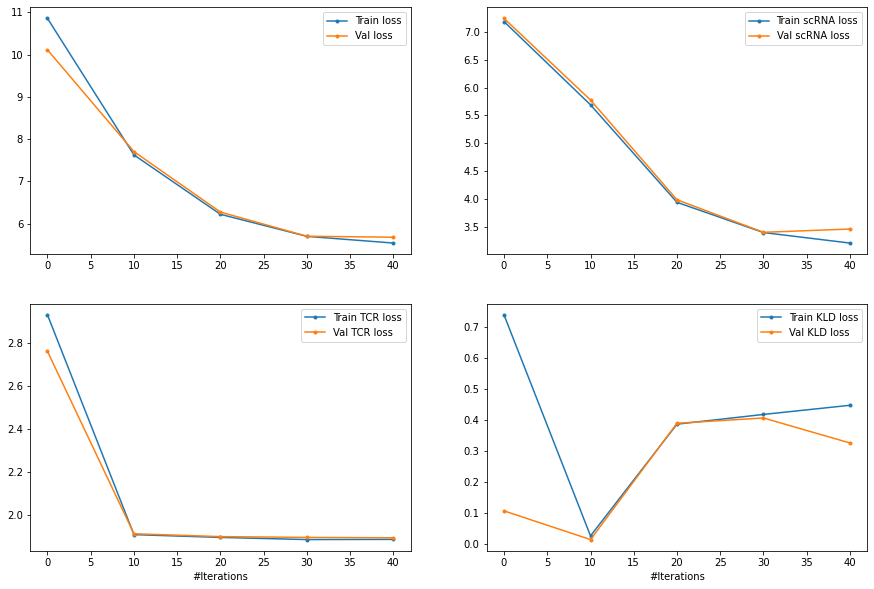

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['epoch'], model.train_history['loss'], '.-', label='Train loss');
plt.plot(model.history['epoch'], model.history['loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['epoch'], model.train_history['scRNA_loss'], '.-', label='Train scRNA loss');
plt.plot(model.history['epoch'], model.history['scRNA_loss'], '.-', label='Val scRNA loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['epoch'], model.train_history['TCR_loss'], '.-', label='Train TCR loss');
plt.plot(model.history['epoch'], model.history['TCR_loss'], '.-', label='Val TCR loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['epoch'], model.train_history['KLD_loss'], '.-', label='Train KLD loss');
plt.plot(model.history['epoch'], model.history['KLD_loss'], '.-', label='Val KLD loss');
plt.xlabel('#Iterations');
plt.legend();


# Predict

In [25]:
z = model.get_latent(
    adatas=[wu2020, bcc],
    names=['wu2020','bcc'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=['patient']
)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Batch: 100%|███████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.41it/s]


In [26]:
z

AnnData object with n_obs × n_vars = 8826 × 16
    obs: 'barcode', 'dataset', 'patient', 'batch'

In [27]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'patient' as categorical


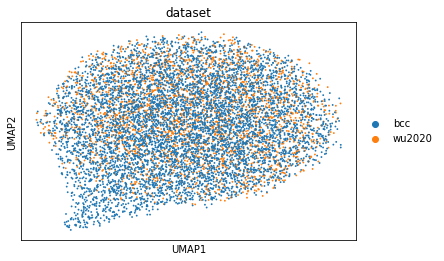

In [28]:
sc.pl.umap(z, color=['dataset'], ncols=1)

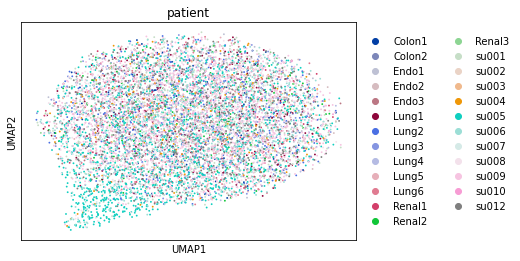

In [29]:
sc.pl.umap(z, color=['patient'])